# Course Evaluation PDF Extractor
This notebook extracts course information from course evaluation PDFs.

In [ ]:
# Uncomment and run this cell if packages need
# !pip install pdfplumber pandas tqdm matplotlib seaborn

In [3]:
import pdfplumber
import re
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Define Functions

In [5]:
# Function to extract course information from a PDF
def extract_course_info(pdf_path):
    """
    Extract course information from a course evaluation PDF.
    
    Args:
        pdf_path (str): Path to the PDF file
        
    Returns:
        dict: Dictionary containing course information
    """
    try:
        # Extract basic info from filename
        filename = os.path.basename(pdf_path)
        
        # Extract professor name
        professor_match = re.search(r'\(([^)]+)\)', filename)
        professor_name = professor_match.group(1) if professor_match else "Unknown"
        
        # Extract semester and year
        semester_match = re.search(r'^(SP|FL)(\d{4})', filename)
        semester = f"{semester_match.group(1)} {semester_match.group(2)}" if semester_match else "Unknown"
        
        # Extract course code and section
        course_match = re.search(r'(L24|E81)[._](\d+\w*)[._](\d+)', filename)
        if course_match:
            course_code = course_match.group(2)
            section = course_match.group(3)
        else:
            # Try another pattern
            course_match = re.search(r'(L24|E81)\s+(\d+\w*)\s+(\d+)', filename)
            if course_match:
                course_code = course_match.group(2)
                section = course_match.group(3)
            else:
                course_code = "Unknown"
                section = "Unknown"
        
        # Extract text from PDF
        text = ""
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        
        # Extract course name
        course_name = "Unknown"
        course_name_match = re.search(r'Reports for .*?- (.*?)\(', text)
        if course_name_match:
            course_name = course_name_match.group(1).strip()
        
        # Look for Learning section which contains overall course rating
        overall_rating = None
        patterns = [
            r'Learning\s+Competency Statistics\s+Value\s+Mean\s+(\d+\.\d+)',
            r'Learning.*?\nCompetency Statistics\s+Value\s+Mean\s+(\d+\.\d+)',
            r'Learning.*?Mean\s+(\d+\.\d+)',
            r'Learning.*?Mean\s*(\d+\.\d+)'
        ]
        
        for pattern in patterns:
            learning_match = re.search(pattern, text, re.DOTALL)
            if learning_match:
                overall_rating = learning_match.group(1)
                break
        
        return {
            'Filename': filename,
            'Professor': professor_name,
            'Semester': semester,
            'Course Code': course_code,
            'Section': section,
            'Course Name': course_name,
            'Overall Rating': overall_rating
        }
    
    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")
        return {
            'Filename': os.path.basename(pdf_path),
            'Professor': "Error",
            'Semester': "Error",
            'Course Code': "Error",
            'Section': "Error",
            'Course Name': "Error",
            'Overall Rating': None
        }

In [6]:
# Function to process all PDFs in a directory
def process_pdfs(directory):
    """
    Process all PDFs in a directory.
    
    Args:
        directory (str): Directory containing PDF files
        
    Returns:
        pd.DataFrame: DataFrame containing course information
    """
    # Get all PDF files in the directory
    pdf_files = [os.path.join(directory, f) for f in os.listdir(directory) 
                if f.endswith('.pdf') and (f.startswith('SP') or f.startswith('FL'))]
    
    print(f"Found {len(pdf_files)} PDF files to process")
    
    # Process each PDF
    results = []
    for pdf_file in tqdm(pdf_files, desc="Processing PDFs"):
        result = extract_course_info(pdf_file)
        results.append(result)
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Convert Overall Rating to numeric
    df['Overall Rating'] = pd.to_numeric(df['Overall Rating'], errors='coerce')
    
    return df

## Process PDFs

In [ ]:
# Set the directory containing the PDF files
pdf_directory = os.path.expanduser("~/Documents/course_evaluations")

# Process the PDFs
df = process_pdfs(pdf_directory)

Found 63 PDF files to process


Processing PDFs:   0%|          | 0/63 [00:00<?, ?it/s]CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page,

## Analyze Results

In [23]:
# Display basic statistics
print(f"Total files processed: {len(df)}")
print(f"Files with ratings found: {df['Overall Rating'].notna().sum()}")
print(f"Success rate: {df['Overall Rating'].notna().sum() / len(df) * 100:.2f}%")

# Display the professors and their ratings
ratings_df = df[df['Overall Rating'].notna()].sort_values('Overall Rating', ascending=False)
print("\nProfessors and their ratings:")
display(ratings_df[['Professor', 'Course Code', 'Course Name', 'Overall Rating']])

Total files processed: 63
Files with ratings found: 34
Success rate: 53.97%

Professors and their ratings:


,Professor,Course Code,Course Name,Overall Rating
19,Quan Nguyen,417T,Unknown,5.91
23,Netanel Raviv,417T,Unknown,5.33
31,Debashis Mondal,4971,Unknown,5.00
22,Brett Wick,500,Unknown,5.00
10,Soumendra Lahiri,5062,Unknown,5.00
55,Debashis Mondal,591,Unknown,5.00
50,Soumendra Lahiri,579,Unknown,5.00
40,Jimin Ding,5072,Unknown,4.75
43,Bowen Xie,495,Unknown,4.68
33,Robert Lunde,462,Unknown,4.68


## Visualize Results

/var/folders/lj/n9gmwlxx5h51py4yw1x4q9600000gn/T/ipykernel_72118/814362407.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Overall Rating', y='Professor', data=ratings_df, palette='viridis')


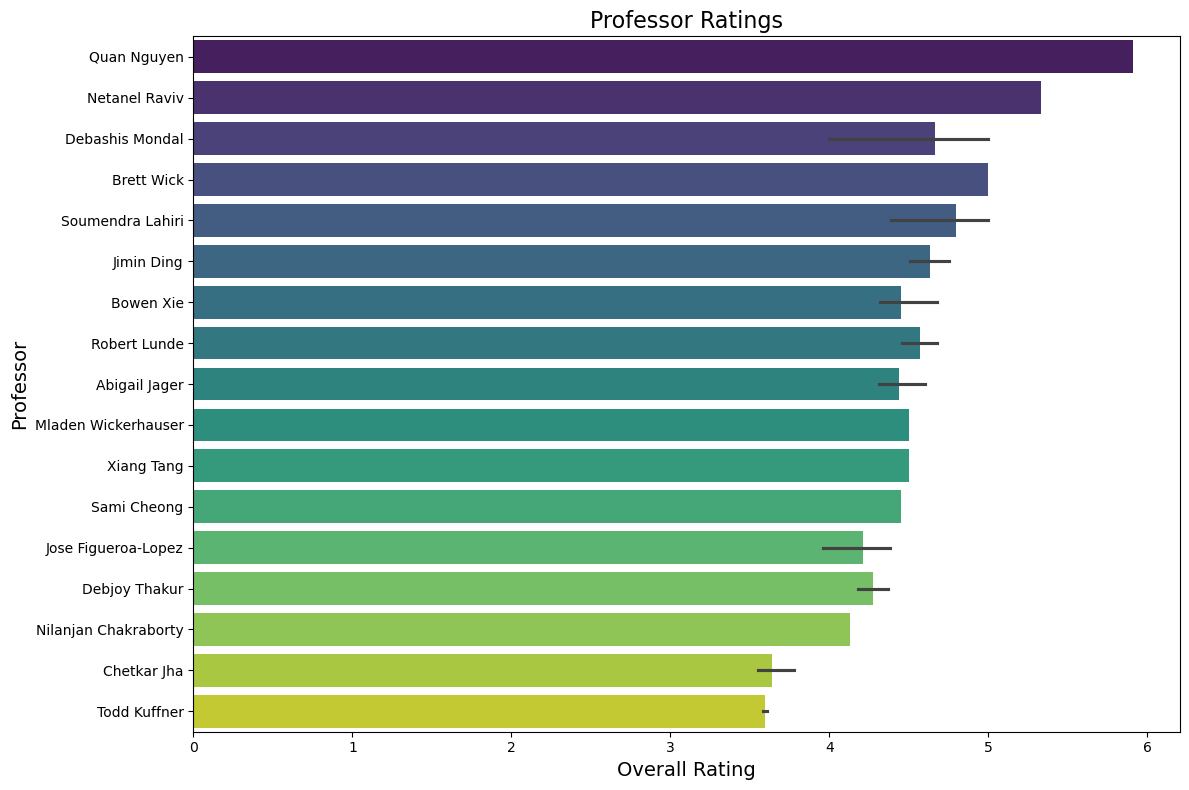

In [25]:
# Create a bar chart of professor ratings
plt.figure(figsize=(12, 8))
sns.barplot(x='Overall Rating', y='Professor', data=ratings_df, palette='viridis')
plt.title('Professor Ratings', fontsize=16)
plt.xlabel('Overall Rating', fontsize=14)
plt.ylabel('Professor', fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# Save the results to a CSV file
output_file = "course_evaluations.csv"
df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to course_evaluations.csv


## Additional Analysis

Average rating by semester:


,Semester,Overall Rating
0,FL 2023,4.393846
1,SP 2024,4.462381


/var/folders/lj/n9gmwlxx5h51py4yw1x4q9600000gn/T/ipykernel_72118/3124555676.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Semester', y='Overall Rating', data=semester_avg, palette='viridis')


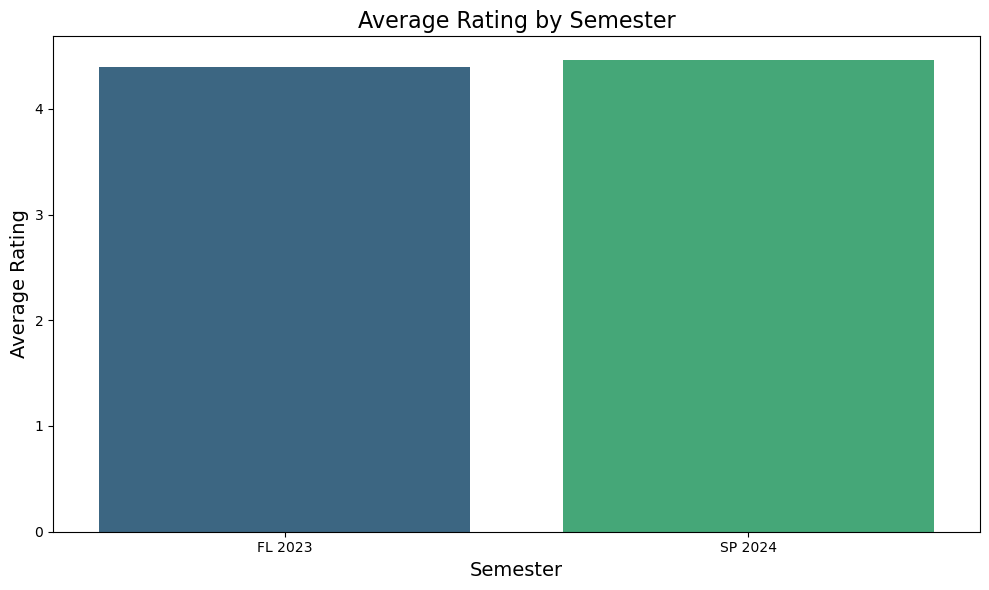

In [30]:
# Average rating by semester
semester_avg = df.groupby('Semester')['Overall Rating'].mean().reset_index()
print("Average rating by semester:")
display(semester_avg)

plt.figure(figsize=(10, 6))
sns.barplot(x='Semester', y='Overall Rating', data=semester_avg, palette='viridis')
plt.title('Average Rating by Semester', fontsize=16)
plt.xlabel('Semester', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.tight_layout()
plt.show()

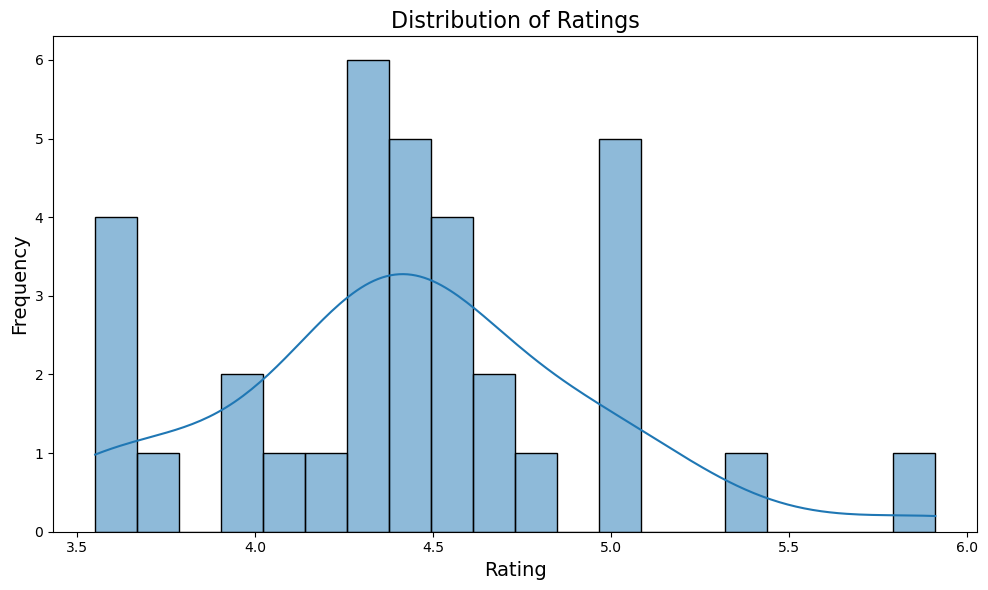

In [32]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['Overall Rating'].dropna(), kde=True, bins=20)
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()